In [1]:
import os
os.getcwd()

'/home/julian/Documents/PythonExperiments/COVIDNet'

In [1]:
from model.model import CovidNet
import torch
import numpy as np
from PIL import Image, ImageOps
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from torchvision import models
from model.model_Grad_CAM import CovidNet_Grad_CAM
from model.model_Deep_Explainer import CovidNet_DE
from skimage import io, img_as_ubyte
import shap
import cv2 

In [2]:
def load_model(path,n_clases=3):
    #checkpoint = torch.load(path+'COVIDNet_best_checkpoint.pth.tar')
    checkpoint = torch.load(path)
    #model = CovidNet(n_clases)
    #model = CovidNet_DE(n_clases)
    model = CovidNet_Grad_CAM(n_clases)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()

    return model

def load_image(img_path):
    if not os.path.exists(img_path):
        print("IMAGE DOES NOT EXIST {}".format(img_path))
    image = cv2.imread(img_path)
    image2 = np.copy(image)
    image2[image2>0]=255
    image2 = image2[:,:,0]
    mask = Image.fromarray(image2.astype('uint8'))
  
    img_adapteq = Image.fromarray(image.astype('uint8'), 'RGB')
    img_adapteq = ImageOps.equalize(img_adapteq,mask=mask)

    preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),#normaliza a [0,1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    image_tensor = preprocess(img_adapteq)

    return image_tensor

def gradientbars(bars,probability,indClases):
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x,y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.atleast_2d(np.linspace(0,1*w/max(probability),256))
        ax.imshow(grad, extent=[x,x+w,y,y+h], aspect="auto", zorder=0, cmap=plt.get_cmap('viridis'),norm=mpl.colors.NoNorm(vmin=0,vmax=1))
        plt.yticks(np.arange(len(probability)), indClases, fontsize=14)
        plt.xticks(np.linspace(0,1,11))
        plt.xlabel('Probabilidad', fontsize=14)
        plt.tight_layout()
    ax.axis(lim)
    #plt.savefig(nameFile, dpi=300)

def eval_image(img_path,model_path):
    image_tensor = load_image(img_path)
    image_tensor = image_tensor.unsqueeze(0)
    model = load_model(model_path,n_clases=3)
    output = model(image_tensor)
    pred = output.detach().numpy()
    probability = np.exp(pred)/np.sum(np.exp(pred))
    ind = np.argmax(probability)
    COVIDxDICT = ['Neumonía','Normal','COVID-19']
    #----------------------------------------------
    fig, ax = plt.subplots() 
    bar = ax.barh(range(len(probability.flatten())),probability.flatten())
    #timestr = time.strftime("%Y%m%d-%H%M%S")
    #nameFile = os.getcwd() + '/CoronavIAruX/static/media/matplotlib_bars/'+timestr
    #nombrecorto = '/static/media/matplotlib_bars/'+timestr+'.png'
    gradientbars(bar,probability.flatten(),COVIDxDICT)
    return(COVIDxDICT[ind])

In [44]:
img_path = '/home/julian/Documents/Datasets/Hackaton/GLOBAL_PathologicalImages/COVID19/1-s2.0-S1684118220300682-main.pdf-003-b1.png'
model_path = '/home/julian/Documents/PythonExperiments/COVIDNet/ModelSavedCoviNet/COVIDNet20200410_1606/'

'COVID-19'

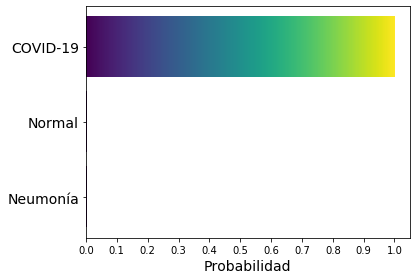

In [6]:
eval_image(img_path,model_path)

In [4]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [45]:
activation = {}
image_tensor = load_image(img_path)
image_tensor = image_tensor.unsqueeze(0)
model = load_model(model_path,n_clases=3)
#model.conv1.register_forward_hook(get_activation('conv1'))
output = model(image_tensor)

In [49]:
output = model.forward(image_tensor)

In [50]:
print(output)

tensor([[-3.4138, -2.6308,  4.5364]], grad_fn=<AddmmBackward>)


In [52]:
output.data.numpy()

array([[-3.4137964, -2.6307828,  4.536449 ]], dtype=float32)

In [19]:
#model=models.resnet50(pretrained=True)

In [47]:
for name, module in model.features._modules.items():
    print(name)
    #print(module)

conv1
conv1_1x1
conv2_1x1
conv3_1x1
conv4_1x1
pexp1_1
pexp1_2
pexp1_3
pexp2_1
pexp2_2
pexp2_3
pexp2_4
pexp3_1
pexp3_2
pexp3_3
pexp3_4
pexp3_5
pexp3_6
pexp4_1
pexp4_2
pexp4_3
Output
MaxPool


In [65]:
activation['conv1'].shape

torch.Size([1, 64, 112, 112])

In [66]:
Activation1 = activation['conv1'].numpy()
Activation1 = np.squeeze(Activation1)
Activation1 = np.moveaxis(Activation1, 0, -1)
Activation1.shape

(112, 112, 64)

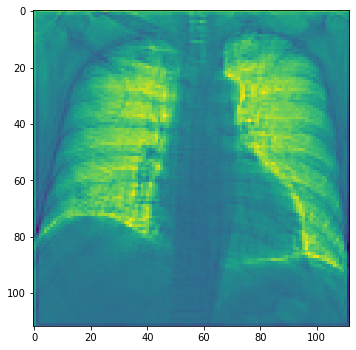

In [79]:
plt.figure(figsize=(5,5))
plt.imshow(Activation1[:,:,11])
plt.tight_layout()
#plt.savefig('Filtro48.png', dpi=300)

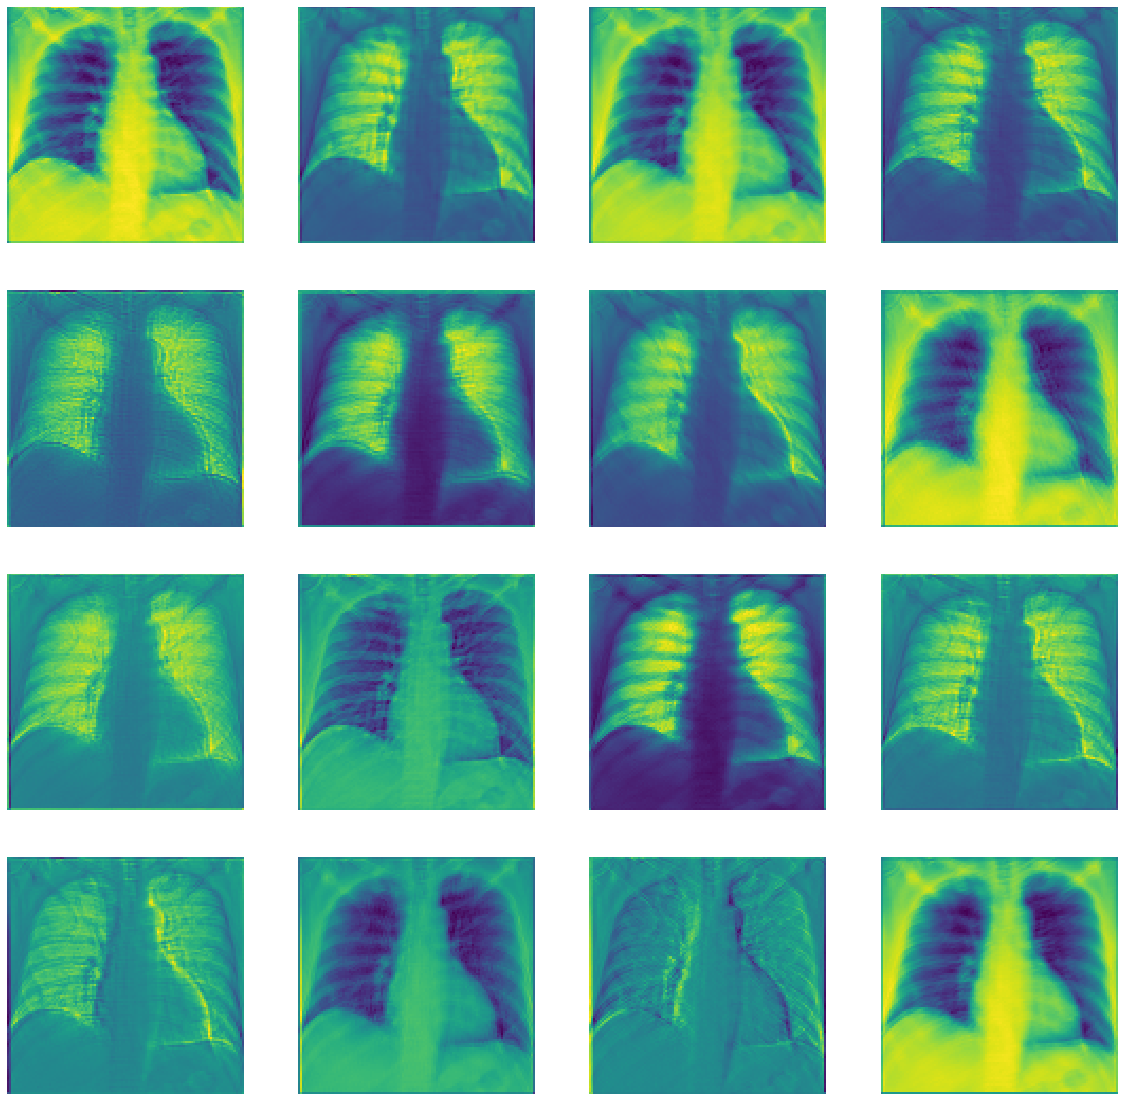

In [82]:
plt.figure(figsize=(20,20))
dim = 0
for i in range(4):
    for j in range(4):
        dim += 1
        # equivalent but more general
        plt.subplot(4, 4, dim)
        plt.imshow(Activation1[:,:,dim-1])
        plt.axis('off')

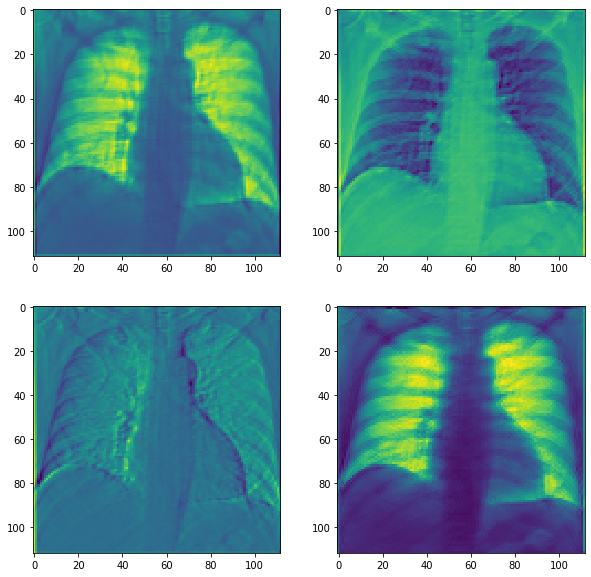

In [77]:
Activation1 = activation['conv1'].numpy()
Activation1 = np.squeeze(Activation1)
Activation1 = np.moveaxis(Activation1, 0, -1)
Activation1.shape
plt.figure(figsize=(10,10))
dim = 0
direc = [1,9,20,10]
for i in range(2):
    for j in range(2):
        dim += 1
        # equivalent but more general
        plt.subplot(2, 2, dim)
        plt.imshow(Activation1[:,:,direc[dim-1]])

In [48]:
activation = {}
image_tensor = load_image(img_path)
image_tensor = image_tensor.unsqueeze(0)
model = load_model(model_path,n_clases=3)
model.pexp2_1.register_forward_hook(get_activation('pexp2_1'))
output = model(image_tensor)
activation['pexp2_1'].shape

torch.Size([1, 512, 28, 28])

In [50]:
Activation1 = activation['pexp2_1'].numpy()
Activation1 = np.squeeze(Activation1)
Activation1 = np.moveaxis(Activation1, 0, -1)
Activation1.shape

(28, 28, 512)

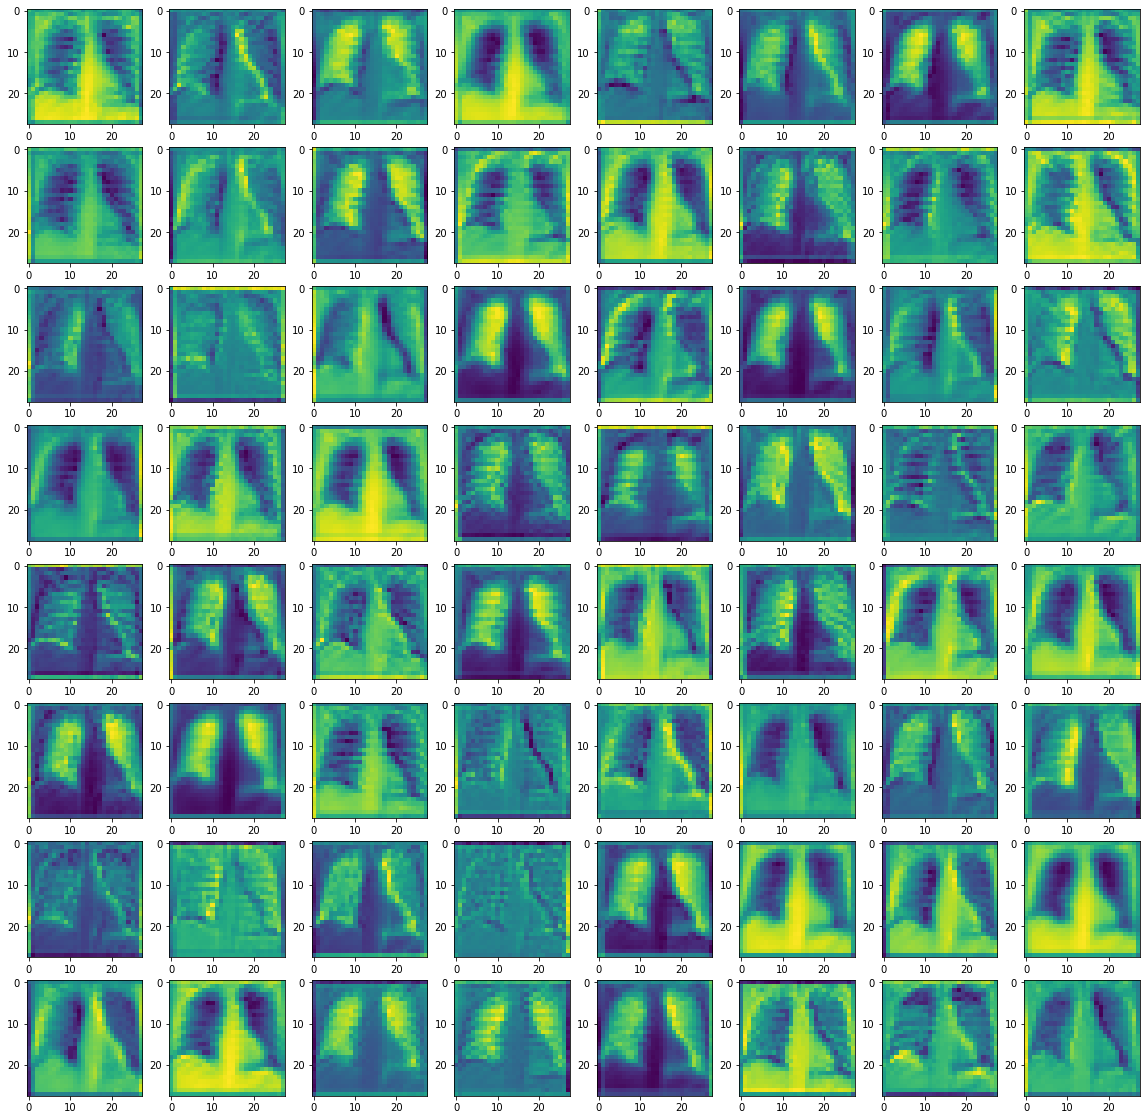

In [51]:
plt.figure(figsize=(20,20))
dim = 0
for i in range(8):
    for j in range(8):
        dim += 1
        # equivalent but more general
        plt.subplot(8, 8, dim)
        plt.imshow(Activation1[:,:,dim-1])

In [ ]:
pepx43

In [60]:
activation = {}
image_tensor = load_image(img_path)
image_tensor = image_tensor.unsqueeze(0)
model = load_model(model_path,n_clases=3)
model.pexp4_3.register_forward_hook(get_activation('pexp4_3'))
output = model(image_tensor)
activation['pexp4_3'].shape

torch.Size([1, 2048, 7, 7])

In [61]:
Activation1 = activation['pexp4_3'].numpy()
Activation1 = np.squeeze(Activation1)
Activation1 = np.moveaxis(Activation1, 0, -1)
Activation1.shape

(7, 7, 2048)

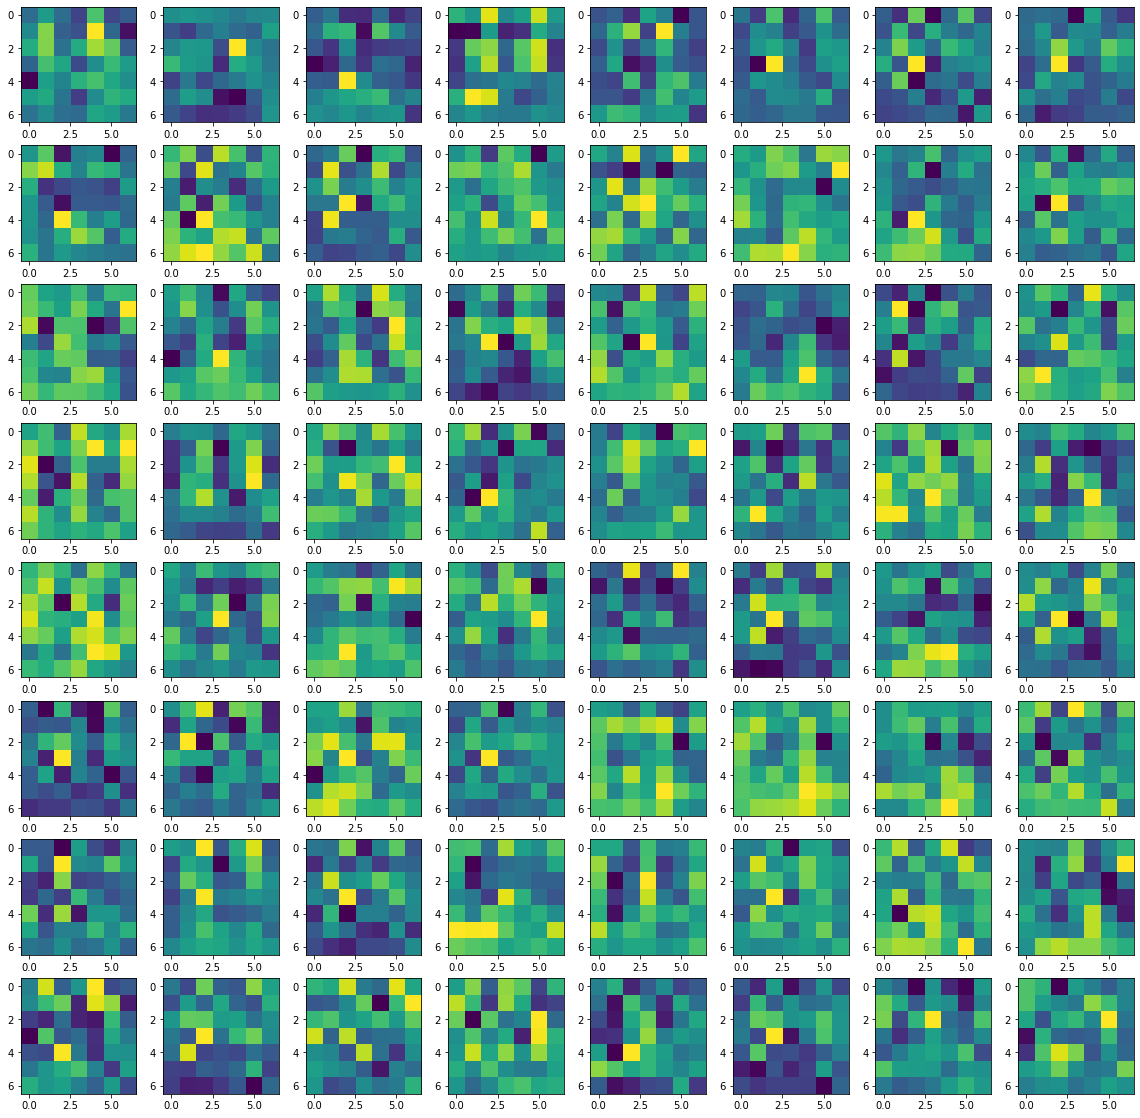

In [62]:
plt.figure(figsize=(20,20))
dim = 0
for i in range(8):
    for j in range(8):
        dim += 1
        # equivalent but more general
        plt.subplot(8, 8, dim)
        plt.imshow(Activation1[:,:,dim-1])

## Grad-CAM

In [4]:
from grad_cam_function import main
from utils import read_filepaths

In [5]:
class Args(object):
    def __init__(self, x, y, z, w):
        self.use_cuda = x
        self.image_path = y
        self.saved_model = z
        self.path_save = w

In [8]:
datafold = '/home/julian/Documents/PythonExperiments/COVIDNet/Datos/DatosExperimentos_3/CroppedSegmentedImages/'
path_save = '/home/julian/Documents/PythonExperiments/COVIDNet/Datos/DatosExperimentos_3/Grad_CAM_CroppedSegmentedImages_test/'
for fold in range(5):
    testfile = '/home/julian/Documents/PythonExperiments/COVIDNet/Datos/DatosExperimentos_3/test_split_fold_'+str(fold)+'.txt'
    paths, labels = read_filepaths(testfile)
    
    for j,file in enumerate(paths):
        image_name = datafold + file
        saved_model = '/home/julian/Documents/PythonExperiments/COVIDNet/ModelSavedCoviNet/Exp3_CroppedSegmentedImages_Fold_'+str(fold)+'/CovidNet_Grad_CAM_best_checkpoint.pth.tar'
        args = Args(True,image_name,saved_model,path_save)
        main(args)

Clase=COVID-19-Samples=802
Clase=normal-Samples=4954
Clase=pneumonia-Samples=2410
Clase=COVID-19-Samples=800
Clase=normal-Samples=4961
Clase=pneumonia-Samples=2407


KeyboardInterrupt: 

In [13]:
file

'1.3.12.2.1107.5.3.56.2693.11.202003230734480609.DC3.png'

In [8]:
#directory = '/home/julian/Documents/PythonExperiments/COVIDNet/data/test/'
directory = '/home/julian/Documents/PythonExperiments/COVIDNet/segmented_data/test/'
arr = os.listdir(directory + '.')
for j,file in enumerate(arr):
    image_name = directory + file
    args = Args(True,image_name,'/home/julian/Documents/PythonExperiments/COVIDNet/ModelSavedCoviNet/COVIDNet20200414_2222_entrenamiento_segmented/CovidNet_Grad_CAM_best_checkpoint.pth.tar','/home/julian/Documents/PythonExperiments/COVIDNet/Grad_CAM_Images_segmented/')
    main(args)

## Embedings

In [72]:
model_path = '/home/julian/Documents/PythonExperiments/COVIDNet/ModelSavedCoviNet/Exp3_CroppedSegmentedImages_Fold_0/CovidNet_Grad_CAM_best_checkpoint.pth.tar'
trainfile = '/home/julian/Documents/PythonExperiments/COVIDNet/Datos/DatosExperimentos_3/train_split_fold_0.txt'
testfile = '/home/julian/Documents/PythonExperiments/COVIDNet/Datos/DatosExperimentos_3/test_split_fold_0.txt'
train_path = '/home/julian/Documents/PythonExperiments/COVIDNet/Datos/DatosExperimentos_3/CroppedSegmentedImages/'
test_path = '/home/julian/Documents/PythonExperiments/COVIDNet/Datos/DatosExperimentos_3/CroppedSegmentedImages/'

In [73]:
from utils import read_filepaths
paths, labels = read_filepaths(trainfile)

Clase=COVID-19-Samples=43272
Clase=normal-Samples=44987
Clase=pneumonia-Samples=43408


In [74]:
len(paths)

131667

In [75]:
def Get_Label(path,label):
    if (path.find('BIMCV_') != -1):
            DB = 'BIMCV'
    elif (path.find('HM1_') != -1):
        DB = 'HM'
    elif (path.find('HM2_') != -1):
        DB = 'HM'
    elif (path.find('ACT_') != -1):
        DB = 'ACT'
    elif (path.find('CRXNIH_') != -1):
        DB = 'CRXNIH'
    elif (path.find('NIH_') != -1):
        DB = 'NIH'
    elif (path.find('CHS_') != -1):
        DB = 'CHS'
    elif (path.find('MOS_') != -1):
        DB = 'MOS'
    elif (path.find('CHEXPERT_') != -1):
        DB = 'CHEXPERT'
    elif (path.find('MIMIC_') != -1):
        DB = 'MIMIC'
    return DB + ' ' + '('+label+')'

### Hook a una capa dentro de un módulo

In [ ]:
model = load_model(model_path,n_clases=3)
#model.cuda()
model.classifier._modules['5'].register_forward_hook(get_activation('5'))
#image_tensor = load_image(train_path + paths[1])
#image_tensor.unsqueeze(0)
Embeb = np.zeros((len(paths),256))
DB_Label = []
for i in range(len(paths)):#len(paths)
    if (i % 100) == 0:
        print(i)
    image_tensor = load_image(train_path + paths[i])
    image_tensor = image_tensor.unsqueeze(0)
    #image_tensor = torch.cat((image_tensor,image_tensor2),0)
    #image_tensor.cuda()
    activation = {}
    output = model(image_tensor)
    temp = activation['5'].numpy()
    Embeb[i,:] = np.squeeze(temp)
    DB_Label.append(Get_Label(paths[i],labels[i]))
    #Embeb = np.moveaxis(Embeb, 0, -1)
    #Activation1.shape

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [ ]:
image_tensor.shape

In [ ]:
Embeb.shape

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
labels = np.array(labels)

In [ ]:
paths2, labels2 = read_filepaths(testfile)

In [ ]:
EmbebTest = np.zeros((len(paths2),256))
DB_Label_test = []
for i in range(len(paths2)):#len(paths)
    #print(i)
    image_tensor = load_image(test_path + paths2[i])
    image_tensor = image_tensor.unsqueeze(0)
    #image_tensor.cuda()
    activation = {}
    output = model(image_tensor)
    temp = activation['5'].numpy()
    EmbebTest[i,:] = np.squeeze(temp)
    DB_Label_test.append(Get_Label(paths2[i],labels2[i]))
    #Embeb = np.moveaxis(Embeb, 0, -1)
    #Activation1.shape

In [ ]:
labels2 = np.array(labels2)

In [ ]:
Embeb3 = np.r_[Embeb,EmbebTest]
Embeb3.shape

In [ ]:
X_embedded3 = TSNE(n_components=2).fit_transform(Embeb3)

In [ ]:
X_embedded3.shape

In [64]:
#np.savez('CroppedSegmentedImages_t-SNE', Embeb,EmbebTest,X_embedded3, labels,labels2,DB_Label,DB_Label_test)
#load 
npzfile = np.load('CroppedSegmentedImages_t-SNE_2.npz')
Embeb = npzfile['arr_0']
EmbebTest = npzfile['arr_1']
X_embedded3 = npzfile['arr_2']
labels = npzfile['arr_3']
labels2 = npzfile['arr_4']
DB_Label = npzfile['arr_5']
DB_Label_test = npzfile['arr_6']

In [65]:
labels.shape

(131667,)

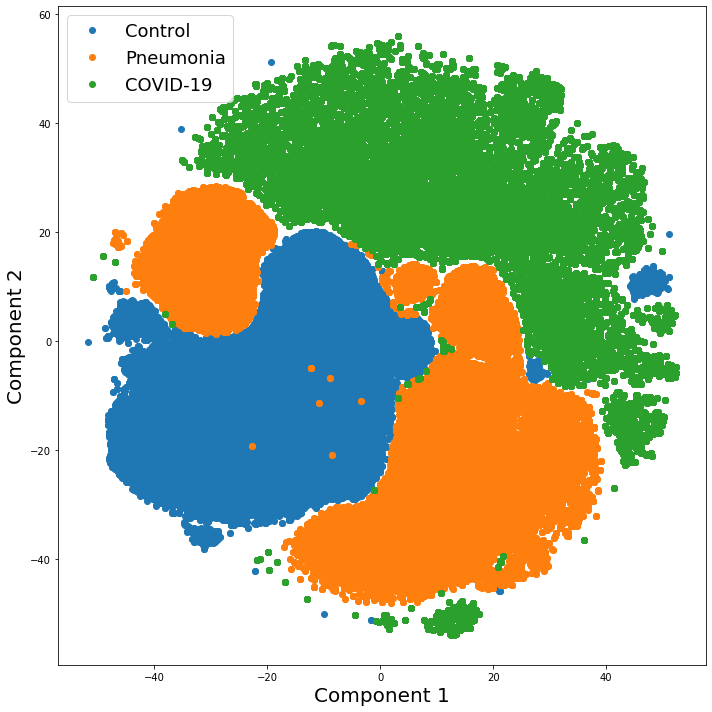

In [66]:
X_embedded = X_embedded3[:131667,:]
plt.figure(figsize=(10,10))
ind = labels == 'normal'
plt.plot(X_embedded[ind,0],X_embedded[ind,1],'.',markersize=12,label='Control')
ind = labels == 'pneumonia'
plt.plot(X_embedded[ind,0],X_embedded[ind,1],'.',markersize=12,label='Pneumonia')
ind = labels == 'COVID-19'
plt.plot(X_embedded[ind,0],X_embedded[ind,1],'.',markersize=12,label='COVID-19')
plt.legend(fontsize=18)
plt.xlabel('Component 1',fontsize=20)
plt.ylabel('Component 2',fontsize=20)
plt.tight_layout()
#plt.savefig('Exp3_CroppedSegmentedImages_t-SNE_training_v2.png',dpi=300)

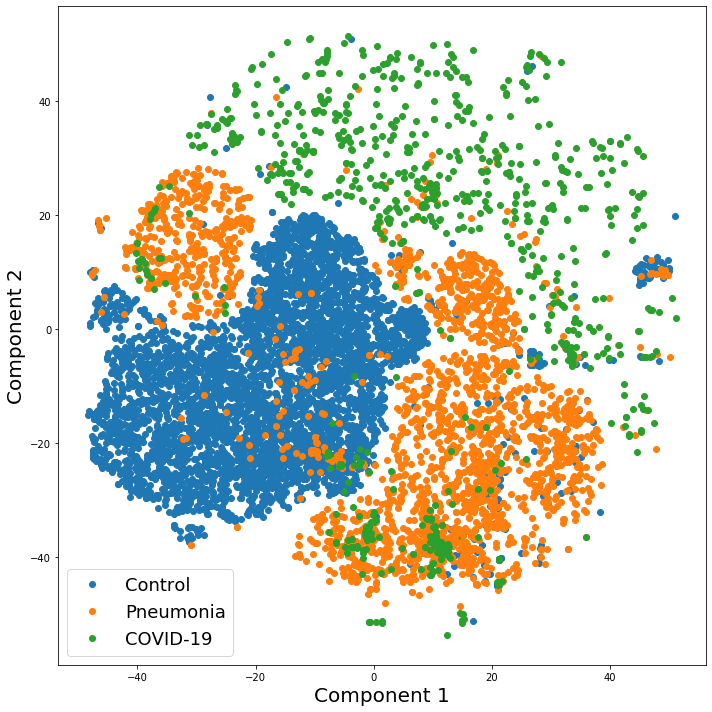

In [67]:
X_embedded2 = X_embedded3[131667:,:]
plt.figure(figsize=(10,10))
ind = labels2 == 'normal'
plt.plot(X_embedded2[ind,0],X_embedded2[ind,1],'.',markersize=12,label='Control')
ind = labels2 == 'pneumonia'
plt.plot(X_embedded2[ind,0],X_embedded2[ind,1],'.',markersize=12,label='Pneumonia')
ind = labels2 == 'COVID-19'
plt.plot(X_embedded2[ind,0],X_embedded2[ind,1],'.',markersize=12,label='COVID-19')
plt.legend(fontsize=18)
plt.xlabel('Component 1',fontsize=20)
plt.ylabel('Component 2',fontsize=20)
plt.tight_layout()
#plt.savefig('Exp3_CroppedSegmentedImages_t-SNE_test_v2.png',dpi=300)

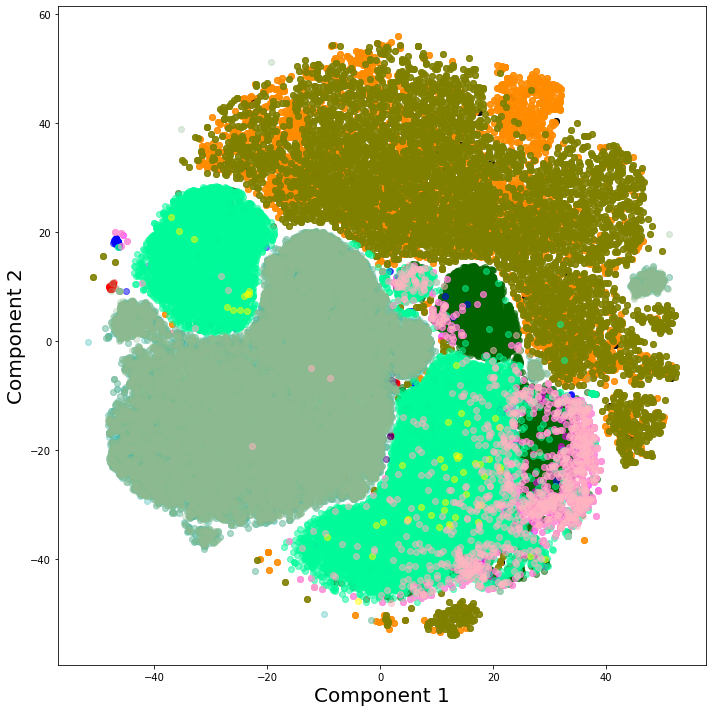

In [68]:
import matplotlib
#cmap = matplotlib.cm.get_cmap('tab20b')
cmap = ['black','dimgrey','darkorange','darkgreen','red','blue','lightseagreen','fuchsia','olive','mediumspringgreen','indigo','yellow','darkseagreen','lightpink']
DB_Label = np.array(DB_Label)
DB_Label_unique = np.unique(DB_Label)
#colors = np.linspace(0, 1, num=DB_Label_unique.shape[0])
plt.figure(figsize=(10,10))
for DB_class,color in zip(DB_Label_unique,cmap):
    ind = DB_Label == DB_class
    plt.plot(X_embedded[ind,0],X_embedded[ind,1],'.',markersize=12,label=DB_class,c=color,alpha=0.3)
#plt.legend(fontsize=18,bbox_to_anchor=(1, 0.8), loc='upper left', ncol=1)
plt.xlabel('Component 1',fontsize=20)
plt.ylabel('Component 2',fontsize=20)
plt.tight_layout()
plt.savefig('Exp3_CroppedSegmentedImages_t-SNE_train_v3_DB_Nolegend.png',dpi=300)

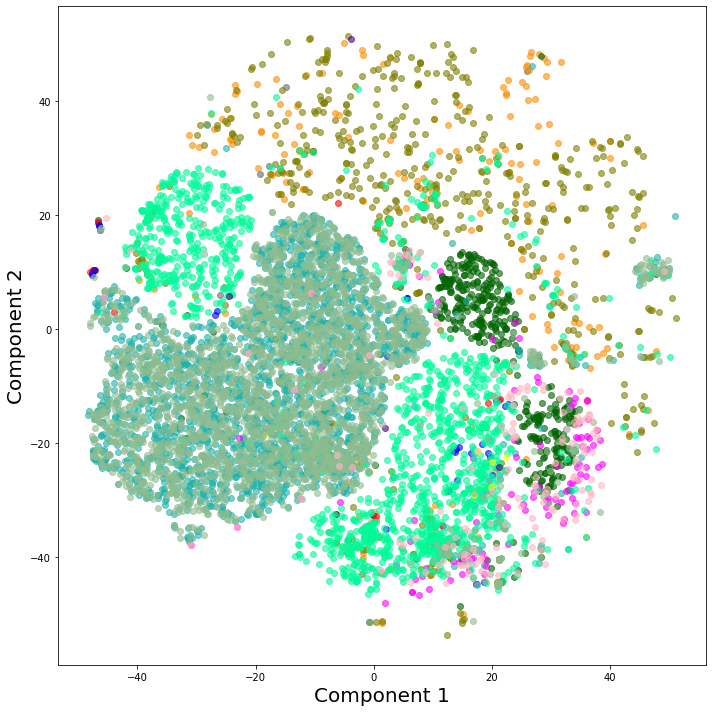

In [69]:
DB_Label_test = np.array(DB_Label_test)
DB_Label_test_unique = np.unique(DB_Label_test)
colors = np.linspace(0, 1, num=DB_Label_unique.shape[0])
plt.figure(figsize=(10,10))
for DB_class,color in zip(DB_Label_test_unique,cmap):
    ind = DB_Label_test == DB_class
    plt.plot(X_embedded2[ind,0],X_embedded2[ind,1],'.',markersize=12,label=DB_class,c=color,alpha=0.6)
#plt.legend(mode="expand",fontsize=18,bbox_to_anchor=(-0.0, 1.22, 1.0, 0), loc='upper center', ncol=4)
plt.xlabel('Component 1',fontsize=20)
plt.ylabel('Component 2',fontsize=20)
plt.tight_layout()
plt.savefig('Exp3_CroppedSegmentedImages_t-SNE_test_v3_DB_Nolegend.png',dpi=300)

(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0)

# Heatmap promedio por clase

In [14]:
paths2, labels2 = read_filepaths(testfile)

Clase=COVID-19-Samples=38
Clase=normal-Samples=2128
Clase=pneumonia-Samples=120


In [15]:
np.unique(labels2)

array(['COVID-19', 'normal', 'pneumonia'], dtype='<U9')

In [16]:
name_files = []
for i in range(len(paths2)):
    name_files.append(paths2[i].split('.')[0])

In [37]:
directory = '/home/julian/Documents/PythonExperiments/COVIDNet/Grad_CAM_Images_segmented/cam/'
arr = os.listdir(directory + '.')
Normal_heatmap = np.zeros((224,224,3))
Pneumo_heatmap = np.zeros((224,224,3))
Covid_heatmap = np.zeros((224,224,3))
for j,file in enumerate(arr):
    img_path = directory + file
    file2 = file.split('.')[0]
    file2 = file2[4:]
    ind = name_files.index(file2)
    image = Image.open(img_path).convert('RGB')
    image = np.array(image)
    if labels2[ind]=='normal':
        Normal_heatmap += image/255
    elif labels2[ind]=='pneumonia':
        Pneumo_heatmap += image/255
    elif labels2[ind]=='COVID-19':
        Covid_heatmap += image/255
    else:
        print('clase no encontrada')
Normal_heatmap /= 2128
Pneumo_heatmap /= 120
Covid_heatmap /= 38

In [40]:
np.min(Normal_heatmap)

0.019681556833259815

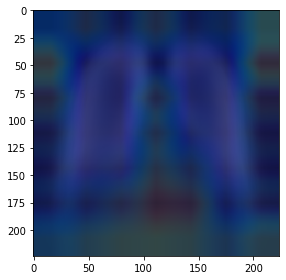

In [43]:
io.imshow(Normal_heatmap)
io.imsave('AverageHM_Normal_segmented.png',img_as_ubyte(Normal_heatmap))

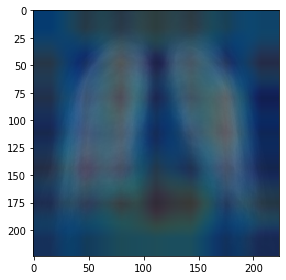

In [44]:
io.imshow(Pneumo_heatmap)
io.imsave('AverageHM_Neumonia_segmented.png',img_as_ubyte(Pneumo_heatmap))

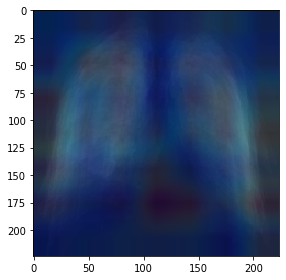

In [45]:
io.imshow(Covid_heatmap)
io.imsave('AverageHM_COVID_segmented.png',img_as_ubyte(Covid_heatmap))

# Deep Explainer

In [4]:
from COVIDXDataset.dataset import COVIDxDataset
from torch.utils.data import DataLoader

In [5]:
data_path = '/home/julian/Documents/PythonExperiments/COVIDNet/Datos/DatosExperimentos_2/CroppedSegmentedImages/'
model_path = '/home/julian/Documents/PythonExperiments/COVIDNet/ModelSavedCoviNet/Exp2_CroppedSegmentedImages_Model_DE_Fold_0/CovidNet_DE_best_checkpoint.pth.tar'

In [6]:
model = load_model(model_path,n_clases=3)

In [8]:
directory = data_path# + 'train/'
arr = os.listdir(directory + '.')
Average_image = np.zeros((3,224,224))
count = 0
for j,file in enumerate(arr):
    img_path = directory + file
    image = load_image(img_path)
    image = image.numpy()
    Average_image += image
    count += 1
Average_image /= count

In [9]:
np.save('Exp2_CroppedSegmentedImage_Average.npy',Average_image)

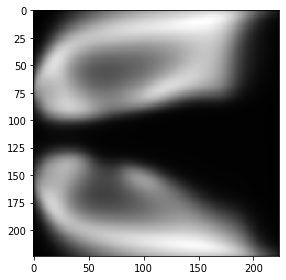

In [10]:
Average_image = np.load('Exp2_CroppedSegmentedImage_Average.npy')
Average_image_plot = np.zeros((3,224,224))
for j in range(3):
    Average_image_plot[j,:,:] = (Average_image[j,:,:]-np.min(Average_image[j,:,:]))/(np.max(Average_image[j,:,:])-np.min(Average_image[j,:,:]))
io.imshow(np.swapaxes(Average_image_plot,0,2))

In [11]:
background = torch.tensor(Average_image)
background = torch.unsqueeze(background, 0)

In [12]:
val_loader = COVIDxDataset(mode='test', n_classes=3, dataset_path=data_path,
                               dim=(224, 224))
test_params = {'batch_size': 16,
                   'shuffle': True,
                   'num_workers': 4}
val_generator = DataLoader(val_loader, **test_params)

Clase=COVID-19-Samples=797
Clase=normal-Samples=2533
Clase=pneumonia-Samples=513
test examples =  3843


In [13]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(val_generator))
images, label = batch

#background = images[:12]
test_images = images[:3]

e = shap.DeepExplainer(model, background.float())
shap_values = e.shap_values(test_images)

In [14]:
images.shape

torch.Size([16, 3, 224, 224])

In [15]:
label[0:16]

tensor([1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2])

In [16]:
len(shap_values)

3

In [17]:
shap_values[0].shape

(3, 3, 224, 224)

In [18]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

In [19]:
shap_numpy[0].shape

(3, 224, 224, 3)

In [20]:
test_numpy.shape

(3, 224, 224, 3)

In [21]:
for i in range(test_numpy.shape[0]):
    for j in range(3):
        test_numpy[i,:,:,j] = (test_numpy[i,:,:,j]-np.min(test_numpy[i,:,:,j]))/(np.max(test_numpy[i,:,:,j])-np.min(test_numpy[i,:,:,j]))

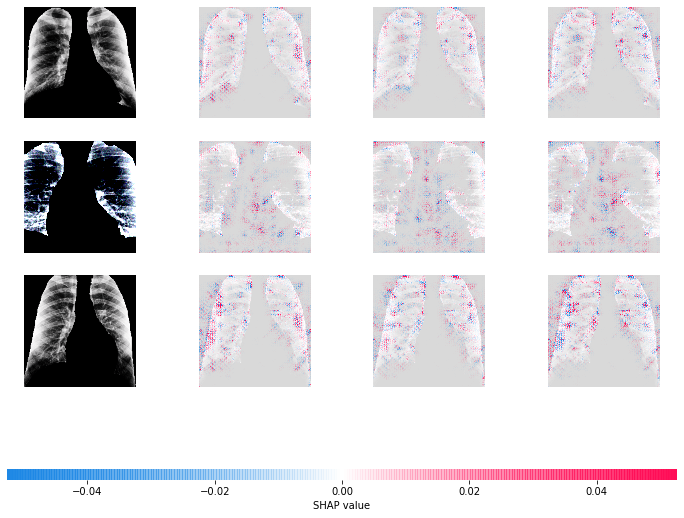

In [22]:
# plot the feature attributions
shap.image_plot(shap_numpy, test_numpy)

# Validaciones

In [64]:
model_path = '/home/julian/Documents/PythonExperiments/COVIDNet/ModelSavedCoviNet/Exp3_OrgImages_Fold_4/CovidNet_Grad_CAM_best_checkpoint.pth.tar'
testfile = '/home/julian/Documents/PythonExperiments/COVIDNet/Datos/DatosExperimentos_3/test_split_fold_4.txt'
test_path = '/home/julian/Documents/PythonExperiments/COVIDNet/Datos/DatosExperimentos_3/OrgImages/'

In [65]:
from utils import read_filepaths
paths, labels = read_filepaths(testfile)
labels = np.array(labels)

Clase=COVID-19-Samples=799
Clase=normal-Samples=4921
Clase=pneumonia-Samples=2408


In [66]:
model = load_model(model_path,n_clases=3)
scores = np.zeros((len(paths),3))
Position = []
Sensor = []
DB = []
Error = np.zeros(len(paths))
#BIMCV,HM1,HM2,ACT,CRXNIH,NIH,CHS,MOS,CHEXPERT,MIMIC
dataBaseErrors = np.zeros(10)

for i in range(len(paths)):#len(paths)
    if (i % 100) == 0:
        print(i)
    image_tensor = load_image(test_path + paths[i])
    image_tensor = image_tensor.unsqueeze(0)
    output = model(image_tensor)
    pred = output.detach().numpy()
    probability = np.exp(pred)/np.sum(np.exp(pred))
    scores[i,:]=probability
    ind = np.argmax(probability)
    COVIDxDICT = ['pneumonia','normal','COVID-19']   
    
    if COVIDxDICT[ind] != labels[i]:
        Error[i] = 1
    
    if (paths[i].find('_PA_') != -1):
        Position.append('PA')
    elif (paths[i].find('_AP_') != -1):
        Position.append('AP')
    else:
        Position.append('NI')
        
    if (paths[i].find('_CR_') != -1):
        Sensor.append('CR')
    elif (paths[i].find('_DX_') != -1):
        Sensor.append('DX')
    else:
        Sensor.append('NI')
        
        
    if (paths[i].find('BIMCV_') != -1):
            DB.append('BIMCV')
    elif (paths[i].find('HM1_') != -1):
        DB.append('HM1')
    elif (paths[i].find('HM2_') != -1):
        DB.append('HM2')
    elif (paths[i].find('ACT_') != -1):
        DB.append('ACT')
    elif (paths[i].find('CRXNIH_') != -1):
        DB.append('CRXNIH')
    elif (paths[i].find('NIH_') != -1):
        DB.append('NIH')
    elif (paths[i].find('CHS_') != -1):
        DB.append('CHS')
    elif (paths[i].find('MOS_') != -1):
        DB.append('MOS')
    elif (paths[i].find('CHEXPERT_') != -1):
        DB.append('CHEXPERT')
    elif (paths[i].find('MIMIC_') != -1):
        DB.append('MIMIC')    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100


In [67]:
import pandas as pd
df = pd.DataFrame(data=labels,    # values
                 index=[i for i in range(len(labels))],
                 columns=['labels'])
df['ProbNeumonia'] = scores[:,0]
df['ProbControl'] = scores[:,1] 
df['ProbCOVID'] = scores[:,2] 
df['Error'] = Error
df['ProyeccionRX'] = Position
df['Sensor'] = Sensor
df['BaseDatos'] = DB

In [68]:
df[:10]

,labels,ProbNeumonia,ProbControl,ProbCOVID,Error,ProyeccionRX,Sensor,BaseDatos
0,normal,5.547738e-02,1.256400e-05,9.445100e-01,1.0,PA,DX,ACT
1,normal,9.047539e-01,3.872388e-14,9.524611e-02,1.0,PA,CR,ACT
2,normal,2.561267e-02,9.669784e-15,9.743873e-01,1.0,PA,DX,ACT
3,normal,4.745203e-03,1.829790e-09,9.952548e-01,1.0,PA,DX,ACT
4,normal,6.544377e-08,9.999999e-01,6.625720e-18,0.0,PA,DX,CRXNIH
5,normal,1.742950e-08,1.000000e+00,1.826885e-13,0.0,PA,DX,CRXNIH
6,normal,8.196202e-07,9.999991e-01,8.512758e-08,0.0,AP,DX,CRXNIH
7,normal,2.038843e-02,9.796116e-01,1.683976e-08,0.0,PA,DX,CRXNIH
8,normal,4.170539e-01,5.793784e-01,3.567658e-03,0.0,PA,DX,CRXNIH
9,normal,7.411771e-08,9.999999e-01,1.698126e-15,0.0,PA,DX,CRXNIH


In [69]:
df.to_csv('Exp3_OrgImages_Val_Fold_4.csv',index=False,compression = None)

# Buscando el sexo en las BDs de COVID

In [34]:
file = '/media/julian/DataDisk2/Datasets/BIMCV-COVID19/BIMCV-COVID19/bimcv_covid19_posi_head_iter1/participants.tsv'
df = pd.read_csv(file, sep='\t')
df[:10]

,participant,modality_dicom,body_parts,age,gender
0,sub-S03852,['CR'],[['CHEST']],[85],M
1,sub-S03719,['CR'],[['CHEST']],[61],F
2,sub-S03448,['CR'],[['CHEST']],[64],F
3,sub-S03639,['DX'],[['CHEST']],[78],M
4,sub-S03666,['CR'],[['CHEST']],[72],F
5,sub-S03758,['CR'],[['CHEST']],[56],M
6,sub-S04428,"['CR', 'CT']",[['CHEST']],[52],M
7,sub-S03049,['DX'],[['CHEST']],[77],F
8,sub-S04128,"['CR', 'CT']",[['CHEST']],[56],F
9,sub-S04520,['CT'],[['CHEST']],[76],M


In [44]:
file = '/media/julian/DataDisk2/Datasets/HM_Hospitales/20_07_2020/CDSL_01.csv'
df2 = pd.read_csv(file,';')
df2[:10]

,PATIENT ID,EDAD/AGE,SEXO/SEX,DIAG ING/INPAT,F_INGRESO/ADMISSION_D_ING/INPAT,F_ENTRADA_UC/ICU_DATE_IN,F_SALIDA_UCI/ICU_DATE_OUT,UCI_DIAS/ICU_DAYS,RESPIRADOR/MECH.VENT.,F_ALTA/DISCHARGE_DATE_ING,...,SAT_02_PRIMERA/FIRST_URG/EMERG,TA_MAX_PRIMERA/FIRST/EMERG_URG,TA_MIN_PRIMERA/FIRST_URG/EMERG,HORA/TIME_CONSTANT_ULTIMA/LAST_URG/EMERG,FC/HR_ULTIMA/LAST_URG/EMERG,TEMP_ULTIMA/LAST_URG/EMERG,GLU_ULTIMA/LAST_URG/EMERG,SAT_02_ULTIMA/LAST_URG/EMERG,TA_MAX_ULTIMA/LAST_URGEMERG,TA_MIN_ULTIMA/LAST_URG/EMERG
0,1,85,MALE,COVID CONFIRMADO,2020-04-06,NaN,NaN,NaN,SI,2020-04-11,...,95,147,68,1899-12-30 19:12:00,67,36.099998,0,95,147,68
1,2,0,MALE,COVID SOSPECHA,2020-04-08,2020-04-08 14:54:38,2020-04-10 21:24:00,2.0,NaN,2020-04-10,...,0,0,0,NaN,0,0.000000,0,0,0,0
2,3,0,FEMALE,COVID SOSPECHA,2020-04-09,2020-04-09 23:23:09,2020-04-10 21:22:03,1.0,NaN,2020-04-10,...,0,0,0,NaN,0,0.000000,0,0,0,0
3,4,0,MALE,COVID SOSPECHA,2020-04-10,2020-04-10 01:56:08,2020-04-10 21:23:03,0.0,NaN,2020-04-10,...,0,0,0,NaN,0,0.000000,0,0,0,0
4,5,0,FEMALE,COVID SOSPECHA,2020-04-10,2020-04-10 02:14:24,2020-04-11 20:14:02,1.0,NaN,2020-04-11,...,0,0,0,NaN,0,0.000000,0,0,0,0
5,6,0,MALE,COVID SOSPECHA,2020-04-10,2020-04-10 02:24:57,2020-04-11 21:39:13,1.0,NaN,2020-04-11,...,0,0,0,NaN,0,0.000000,0,0,0,0
6,7,66,FEMALE,COVID CONFIRMADO,2020-03-27,2020-03-27 18:51:30,2020-03-27 18:52:33,0.0,SI,NaN,...,0,0,0,NaN,0,0.000000,0,0,0,0
7,8,68,FEMALE,COVID CONFIRMADO,2020-03-28,2020-03-31 01:05:44,2020-03-31 02:25:58,0.0,SI,2020-03-31,...,0,0,0,NaN,0,0.000000,0,0,0,0
8,9,68,FEMALE,COVID CONFIRMADO,2020-03-31,2020-03-31 03:00:27,2020-05-12 17:40:53,42.0,SI,2020-05-14,...,0,0,0,NaN,0,0.000000,0,0,0,0
9,10,63,MALE,COVID CONFIRMADO,2020-04-01,2020-04-01 16:52:45,2020-04-21 12:36:29,20.0,SI,2020-05-03,...,0,0,0,NaN,0,0.000000,0,0,0,0


In [53]:
file = '/media/julian/DataDisk2/Datasets/HM_Hospitales/24_04_2020/01.csv'
df3 = pd.read_csv(file,';',usecols=['PATIENT ID', 'SEXO/SEX'])
df3[:10]

,PATIENT ID,SEXO/SEX
0,577,MALE
1,44,FEMALE
2,585,FEMALE
3,587,MALE
4,586,FEMALE
5,588,MALE
6,589,MALE
7,590,FEMALE
8,593,MALE
9,592,MALE


In [55]:
from utils import read_filepaths
paths, labels = read_filepaths(testfile)
labels = np.array(labels)

Clase=COVID-19-Samples=799
Clase=normal-Samples=4921
Clase=pneumonia-Samples=2408


In [82]:
test_path = '/home/julian/Documents/PythonExperiments/COVIDNet/Datos/DatosExperimentos_3/CroppedSegmentedImages/'
TSamples = np.zeros((2,5))
Correct = np.zeros((2,5))

for fold in range(5):
    print(fold)
    model_path = '/home/julian/Documents/PythonExperiments/COVIDNet/ModelSavedCoviNet/Exp3_CroppedSegmentedImages_Fold_'+str(fold)+'/CovidNet_Grad_CAM_best_checkpoint.pth.tar'
    testfile = '/home/julian/Documents/PythonExperiments/COVIDNet/Datos/DatosExperimentos_3/test_split_fold_'+str(fold)+'.txt'
    
    paths, labels = read_filepaths(testfile)
    labels = np.array(labels)

    model = load_model(model_path,n_clases=3)
    Sexo=[]
    Error = []
    COVIDxDICT = ['pneumonia','normal','COVID-19'] 
    for i in range(len(paths)):#len(paths)
        if labels[i] == 'COVID-19':
            if (paths[i].find('ACT_') == -1):
                image_tensor = load_image(test_path + paths[i])
                image_tensor = image_tensor.unsqueeze(0)
                output = model(image_tensor)
                pred = output.detach().numpy()
                probability = np.exp(pred)/np.sum(np.exp(pred))

                ind = np.argmax(probability)
                if COVIDxDICT[ind] != labels[i]:
                    Error.append(0)
                else:
                    Error.append(1)
        
                if (paths[i].find('BIMCV_') != -1):
                    #DB = 'BIMCV'
                    temp = paths[i].split('__')
                    Pat_ID = temp[4]
                    Sexo.append(df.loc[df['participant']=='sub-S0'+Pat_ID]['gender'].values[0])   
                elif (paths[i].find('HM1_') != -1):
                    #DB.append('HM1')
                    temp = paths[i].split('__')
                    Pat_ID = temp[5]
                    Sexo.append(df2.loc[df2['PATIENT ID']==int(Pat_ID)]['SEXO/SEX'].values[0][0])
                elif (paths[i].find('HM2_') != -1):
                    temp = paths[i].split('__')
                    Pat_ID = temp[5]
                    try:
                        Sexo.append(df3.loc[df3['PATIENT ID']==int(Pat_ID)]['SEXO/SEX'].values[0][0])
                    except:
                        Sexo.append('M')
    Error = np.array(Error)
    Sexo = np.array(Sexo)
    TSamples[0,fold]=np.sum(Sexo=='M')
    TSamples[1,fold]=np.sum(Sexo=='F')
    Correct[0,fold] = np.sum(Error[Sexo=='M'])
    Correct[1,fold] = np.sum(Error[Sexo=='F'])
    
temp =  np.sum(TSamples,axis=0)   
print(np.mean(TSamples/temp,axis=1))

temp =  np.sum(Correct,axis=0)   
print(np.mean(Correct/temp,axis=1))

0
Clase=COVID-19-Samples=802
Clase=normal-Samples=4954
Clase=pneumonia-Samples=2410
1
Clase=COVID-19-Samples=800
Clase=normal-Samples=4961
Clase=pneumonia-Samples=2407
2
Clase=COVID-19-Samples=802
Clase=normal-Samples=4966
Clase=pneumonia-Samples=2412
3
Clase=COVID-19-Samples=802
Clase=normal-Samples=5034
Clase=pneumonia-Samples=2409
4
Clase=COVID-19-Samples=799
Clase=normal-Samples=4921
Clase=pneumonia-Samples=2408
[0.63908412 0.36091588]
[0.65215112 0.34784888]


# Estadísticos sobre la validación

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
def Codificacion(clase,COVIDxDICT):
    enc = LabelEncoder().fit(COVIDxDICT)
    y_real = enc.transform(clase.flatten())
    y_real2 = np.copy(y_real)
    y_real[y_real2==0]=2
    y_real[y_real2==2]=0
    return y_real

In [26]:
import pandas as pd
from sklearn.metrics import confusion_matrix


Exp = 'Exp3_SegementedImages_Val_Fold_'
#dfl = []
COVIDxDICT = ['pneumonia','normal','COVID-19'] 
ProyeccionRX = ['PA','AP']
Sensores = ['CR','DX']
PPV_P = np.zeros((2,5,3))
Sensi_P = np.zeros((2,5,3))
F1_P = np.zeros((2,5,3))
PPV_S = np.zeros((2,5,3))
Sensi_S = np.zeros((2,5,3))
F1_S = np.zeros((2,5,3))
Proj_count = np.zeros((2,5,3))
Hits_p_count = np.zeros((2,5,3))
Sens_count = np.zeros((2,5,3))
Hits_s_count = np.zeros((2,5,3))
for i in range(5):
    name = Exp + str(i) + '.csv'
    df = pd.read_csv(name)
    for j,Proyeccion in enumerate(ProyeccionRX):
        df2 = df.loc[df['ProyeccionRX'] == Proyeccion]
        y_pred = np.argmax(df2[['ProbNeumonia', 'ProbControl', 'ProbCOVID']].values,axis=1)
        y_real = Codificacion(df2[['labels']].values,COVIDxDICT)
        _,temp = np.unique(y_real,return_counts=True)
        Proj_count[j,i,:] = temp
        
        CM = confusion_matrix(y_real,y_pred)
        
        Hits_p_count[j,i,:] = np.diag(CM)
        
        #print(np.sum(CM,axis=1))
        PPV_P[j,i,:] = np.diag(CM/np.sum(CM,axis=0))
        Sensi_P[j,i,:]=np.diag(CM/np.sum(CM,axis=1))
        F1_P[j,i,:] = 2*(PPV_P[j,i,:]*Sensi_P[j,i,:])/(PPV_P[j,i,:]+Sensi_P[j,i,:])
        
    for j,sensor in enumerate(Sensores):
        df2 = df.loc[df['Sensor'] == sensor]
        y_pred = np.argmax(df2[['ProbNeumonia', 'ProbControl', 'ProbCOVID']].values,axis=1)
        y_real = Codificacion(df2[['labels']].values,COVIDxDICT)
        
        _,temp = np.unique(y_real,return_counts=True)
        Sens_count[j,i,:] = temp
        
        CM = confusion_matrix(y_real,y_pred)
        
        Hits_s_count[j,i,:] = np.diag(CM)
        
        #print(np.sum(CM,axis=1))
        PPV_S[j,i,:] = np.diag(CM/np.sum(CM,axis=0))
        Sensi_S[j,i,:]=np.diag(CM/np.sum(CM,axis=1))
        F1_S[j,i,:] = 2*(PPV_S[j,i,:]*Sensi_S[j,i,:])/(PPV_S[j,i,:]+Sensi_S[j,i,:])

invalid value encountered in true_divide


In [27]:
temp = np.sum(Proj_count,axis=0)
temp2 = Proj_count/temp
print(np.mean(temp2[0,:,2]))
print(np.mean(temp2[1,:,2]))

0.21191781432516982
0.7880821856748301


In [28]:
temp = np.sum(Hits_p_count,axis=0)
temp2 = Hits_p_count/temp
print(np.mean(temp2[0,:,2]))
print(np.mean(temp2[1,:,2]))

0.17284804572484957
0.8271519542751505


In [195]:
print(PPV_P[0,:,:].mean(0))
print(PPV_P[0,:,:].std(0))

[0.84072095 0.97882408 0.66676304]
[0.01723383 0.00360744 0.04816323]


In [196]:
print(PPV_P[1,:,:].mean(0))
print(PPV_P[1,:,:].std(0))

[0.87391558 0.96031059 0.81822439]
[0.00969973 0.00811508 0.03065455]


In [197]:
print(Sensi_P[0,:,:].mean(0))
print(Sensi_P[0,:,:].std(0))

[0.8719339  0.9708353  0.65233327]
[0.01658364 0.00211817 0.04729819]


In [198]:
print(Sensi_P[1,:,:].mean(0))
print(Sensi_P[1,:,:].std(0))

[0.91661521 0.90653425 0.83620404]
[0.01124442 0.00867845 0.02137108]


In [199]:
print(F1_P[0,:,:].mean(0))
print(F1_P[0,:,:].std(0))

[0.85573823 0.97480793 0.65609516]
[0.00525238 0.00185311 0.0105096 ]


In [200]:
print(F1_P[1,:,:].mean(0))
print(F1_P[1,:,:].std(0))

[0.89465339 0.93259624 0.82647044]
[0.00409365 0.00473574 0.01277438]


In [201]:
df.loc[df['Sensor'] == 'NI'].shape

(5018, 8)

In [29]:
temp = np.sum(Sens_count,axis=0)
temp2 = Sens_count/temp
print(np.mean(temp2[0,:,2]))
print(np.mean(temp2[1,:,2]))

0.7798164079712635
0.2201835920287365


In [30]:
temp = np.sum(Hits_s_count,axis=0)
temp2 = Hits_s_count/temp
print(np.mean(temp2[0,:,2]))
print(np.mean(temp2[1,:,2]))

0.7639056273052925
0.23609437269470743


In [15]:
temp

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [202]:
print(PPV_S[0,:,:].mean(0))
print(PPV_S[0,:,:].std(0))

[0.07895374 0.01666667 0.99006028]
[0.0321121  0.03333333 0.00264255]


In [203]:
print(PPV_S[1,:,:].mean(0))
print(PPV_S[1,:,:].std(0))

[0.59607835 0.99265785 0.86123621]
[0.02065172 0.00148455 0.05408189]


In [204]:
print(Sensi_S[0,:,:].mean(0))
print(Sensi_S[0,:,:].std(0))

[0.77666667 0.04       0.81815375]
[0.13482499 0.08       0.02199425]


In [205]:
print(Sensi_S[1,:,:].mean(0))
print(Sensi_S[1,:,:].std(0))

[0.8993557  0.95747699 0.89485141]
[0.01661872 0.00188112 0.02809537]


In [207]:
ind = np.isnan(F1_S[0,:,:])
F1_S[0,ind]=0

print(np.mean(F1_S[0,:,:],axis=0))
print(np.std(F1_S[0,:,:],axis=0))

[0.14145301 0.02352941 0.89576005]
[0.05198931 0.04705882 0.01248869]


In [208]:
print(F1_S[1,:,:].mean(0))
print(F1_S[1,:,:].std(0))

[0.71683019 0.97474998 0.87729341]
[0.01850762 0.00167442 0.03948866]


# Estadística por DB

In [10]:
import pandas as pd
from sklearn.metrics import confusion_matrix


Exp = 'Exp3_CroppedImages_Val_Fold_'
#dfl = []
COVIDxDICT = ['pneumonia','normal','COVID-19'] 
DBs = ['BIMCV','HM', 'ACT']

DB_count = np.zeros((3,5))
DB_hits_count = np.zeros((3,5))

for i in range(5):
    name = Exp + str(i) + '.csv'
    df = pd.read_csv(name)
    N = df.shape[0]
    for j,DB in enumerate(DBs):
        if DB == 'HM':
            df2 = df.loc[(df['BaseDatos'] == 'HM1') | (df['BaseDatos'] == 'HM2')]
        else:
            df2 = df.loc[df['BaseDatos'] == DB]
        
        DB_count[j,i]=df2.shape[0]
        
        df3 = df2.loc[df2['Error'] == 0]
        
        DB_hits_count[j,i]=df3.shape[0]
        
temp = np.sum(DB_count,axis=0)
temp2 = DB_count/temp
print(np.mean(temp2,axis=1))

temp = np.sum(DB_hits_count,axis=0)
temp2 = DB_hits_count/temp
print(np.mean(temp2,axis=1))

[0.29836479 0.69047716 0.01115805]
[0.26641547 0.72701336 0.00657116]
